In [1]:
import torch
import time
import os
import copy
import json
import random
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from pytorch_tabnet.metrics import Metric
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.metrics import r2_score, mean_squared_error

def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use. 
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True  # slower

fix_random(42)

In [2]:
df = pd.read_csv('dataset.csv')

# PyTorch Device
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print('Using device:', device)

Using device: mps


In [3]:
X = df.drop('rating', axis=1)
Y = df['rating']

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

X_train = X_train.to_numpy()
X_val = X_val.to_numpy()
X_test = X_test.to_numpy()

Y_train = Y_train.to_numpy()
Y_val = Y_val.to_numpy()
Y_test = Y_test.to_numpy()

Y_train = Y_train.reshape(-1, 1)
Y_val = Y_val.reshape(-1, 1)

# PCA
pca = PCA(n_components=0.95)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_val = pca.transform(X_val)
X_test = pca.transform(X_test)

print(f'Number of training samples: {X_train.shape[0]}')
print(f'Number of validation samples: {X_val.shape[0]}')
print(f'Number of testing samples: {X_test.shape[0]}')
print(f'\nNumber of features: {X_train.shape[1]}')

Number of training samples: 9946
Number of validation samples: 1106
Number of testing samples: 2764

Number of features: 552


In [13]:
# hyperparameters
nums_epochs = [200]
batch_sizes = [256, 512, 1024]
patience = [10]
n_d_a = [64]
n_shared = [2]
n_indipendent = [2]
n_step = [6]
gamma = [1.3]
epsilon = [1e-8]

hyperparameters = itertools.product(n_d_a, n_step,n_indipendent,n_shared, gamma, epsilon,nums_epochs, batch_sizes)
n_comb = len(n_d_a)*len(n_step)*len(n_indipendent)*len(n_shared)*len(gamma)*len(epsilon)*len(nums_epochs)*len(batch_sizes)
print (f'Number of hyperparameter combinations: {n_comb}')

Number of hyperparameter combinations: 3


In [14]:
def get_model(n_d_a, n_step,n_indipendent,n_shared, gamma, epsilon):
    model = TabNetRegressor(
        # n_d: the dimensionality of the output space of the feature transformer network (default 64)
        n_d=n_d_a,
        # n_a: the dimensionality of the output space of the attention network (default 64)
        n_a=n_d_a,
        # n_steps: the number of sequential steps in the attention mechanism (default 3)
        n_steps=n_step,
        # gamma: the scaling factor for the feature transformer network (default 1.3)
        gamma=gamma,
        # optimizerm name of optimizer to use (default Adam)
        optimizer_fn=torch.optim.Adam,
        # n_independent: the number of independent feature transformer networks to use (default 2)
        n_independent=n_indipendent,
        # n_shared: the number of shared feature transformer networks to use (default 2)
        n_shared=n_shared,
        # epsilon: a small value to add to the denominator of the feature importance calculation to avoid division by zero (default 1e-15)
        epsilon=epsilon,
        # seed: the random seed to use for reproducibility (default None)
        seed=42,  
        verbose=1
    )
    return model

In [15]:
current_iter = 0

best_model = None
best_mse = float('inf')
criterion = torch.nn.MSELoss()

for n_d_a, n_step,n_indipendent,n_shared, gamma, epsilon,nums_epochs, batch_sizes in hyperparameters:
    current_iter += 1

    print("\nIterations {}/{} - Hyperparameters:  batch_sizes={}, nums_epochs={}, n_d = {}, n_a={}, n_step={}, n_indipendent={}, n_shared={}, gamma={}, epsilon={}".format(
        current_iter, n_comb, batch_sizes, nums_epochs, n_d_a, n_d_a, n_step, n_indipendent, n_shared, gamma, epsilon ))

    model = get_model(n_d_a, n_step, n_indipendent, n_shared, gamma, epsilon)

    # train
    model.fit(
                X_train=X_train,
                y_train=Y_train,
                eval_set=[(X_val, Y_val)],
                eval_metric=['mse'],
                # patience: the number of epochs to wait without improvement in validation loss before early stopping (default 10)
                patience=10,
                # batch_size: the number of samples per batch (default 1024)
                batch_size=batch_sizes,
                # virtual_batch_size: the number of samples per virtual batch (default 128)
                virtual_batch_size=128,
                # num_workers: the number of worker processes to use for data loading (default 0)
                num_workers=0,
                # drop_last: whether to drop the last incomplete batch if the dataset size is not divisible by the batch size (default False)
                drop_last=False,
                # max_epochs: the maximum number of epochs to train for (default 100)
                max_epochs=nums_epochs,
            )

    # Predict
    preds = model.predict(X_test)

    # Calculate the MSE
    mse = mean_squared_error(Y_test, preds)
    
    if mse < best_mse:
        best_mse = mse
        best_model = model
        # # save model
        # torch.save(best_model, 'best_tab_model.pt')
        # # save config
        # with open('best_tab_model_config.json', 'w') as f:
        #     json.dump({'n_d':n_d, 'n_a':n_a, 'n_step':n_step, 'n_indipendent':n_indipendent, 'n_shared':n_shared, 'gamma':gamma, 'epsilon':epsilon, 'batch_sizes':batch_sizes, 'nums_epochs':nums_epochs }, f)
            
            
    print("Model MSE: {:.6f} - Best MSE: {:.6f}".format(mse, best_mse))
    print("Model R2 Score: {:.6f} - Best R2 Score: {:.6f}".format(r2_score(Y_test, preds), r2_score(Y_test, best_model.predict(X_test))))



Iterations 1/3 - Hyperparameters:  batch_sizes=256, nums_epochs=200, n_d = 64, n_a=64, n_step=6, n_indipendent=2, n_shared=2, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.50365 | val_0_mse: 1.54504 |  0:00:08s
epoch 1  | loss: 0.82814 | val_0_mse: 2.3441  |  0:00:15s
epoch 2  | loss: 1.41972 | val_0_mse: 0.52503 |  0:00:23s
epoch 3  | loss: 0.3392  | val_0_mse: 0.33962 |  0:00:31s
epoch 4  | loss: 0.42999 | val_0_mse: 0.22917 |  0:00:38s
epoch 5  | loss: 0.17501 | val_0_mse: 0.16266 |  0:00:46s
epoch 6  | loss: 0.16093 | val_0_mse: 0.10179 |  0:00:53s
epoch 7  | loss: 0.1446  | val_0_mse: 0.10361 |  0:01:03s
epoch 8  | loss: 0.129   | val_0_mse: 0.12423 |  0:01:10s
epoch 9  | loss: 0.12595 | val_0_mse: 0.10593 |  0:01:18s
epoch 10 | loss: 0.12672 | val_0_mse: 0.10242 |  0:01:25s
epoch 11 | loss: 0.12102 | val_0_mse: 0.09676 |  0:01:33s
epoch 12 | loss: 0.12155 | val_0_mse: 0.10163 |  0:01:40s
epoch 13 | loss: 0.11097 | val_0_mse: 0.08814 |  0:01:48s
epoch 14 | loss: 0.10781 | val_0_mse: 0.09479 |  0:01:55s
epoch 15 | loss: 0.11644 | val_0_mse: 0.09452 |  0:02:03s
epoch 16 | loss: 0.10759 | val_0_mse: 0.08897 |  0:02:11s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.007183 - Best MSE: 0.007183
Model R2 Score: 0.967598 - Best R2 Score: 0.967598

Iterations 2/3 - Hyperparameters:  batch_sizes=512, nums_epochs=200, n_d = 64, n_a=64, n_step=6, n_indipendent=2, n_shared=2, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.9253  | val_0_mse: 1.11696 |  0:00:05s
epoch 1  | loss: 1.16417 | val_0_mse: 0.78193 |  0:00:10s
epoch 2  | loss: 0.78197 | val_0_mse: 0.38991 |  0:00:16s
epoch 3  | loss: 0.56054 | val_0_mse: 0.40771 |  0:00:21s
epoch 4  | loss: 0.47881 | val_0_mse: 0.65013 |  0:00:27s
epoch 5  | loss: 0.34076 | val_0_mse: 0.31379 |  0:00:32s
epoch 6  | loss: 0.28584 | val_0_mse: 0.29554 |  0:00:37s
epoch 7  | loss: 0.28838 | val_0_mse: 0.34287 |  0:00:42s
epoch 8  | loss: 0.31299 | val_0_mse: 0.25765 |  0:00:48s
epoch 9  | loss: 0.2484  | val_0_mse: 0.25789 |  0:00:53s
epoch 10 | loss: 0.25658 | val_0_mse: 0.28109 |  0:00:58s
epoch 11 | loss: 0.24377 | val_0_mse: 0.27784 |  0:01:03s
epoch 12 | loss: 0.23854 | val_0_mse: 0.20467 |  0:01:08s
epoch 13 | loss: 0.25227 | val_0_mse: 0.16494 |  0:01:14s
epoch 14 | loss: 0.21669 | val_0_mse: 0.21089 |  0:01:19s
epoch 15 | loss: 0.2136  | val_0_mse: 0.18267 |  0:01:24s
epoch 16 | loss: 0.19864 | val_0_mse: 0.142   |  0:01:29s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.010932 - Best MSE: 0.007183
Model R2 Score: 0.950681 - Best R2 Score: 0.967598

Iterations 3/3 - Hyperparameters:  batch_sizes=1024, nums_epochs=200, n_d = 64, n_a=64, n_step=6, n_indipendent=2, n_shared=2, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 5.28535 | val_0_mse: 2.34439 |  0:00:03s
epoch 1  | loss: 1.77736 | val_0_mse: 1.38072 |  0:00:07s
epoch 2  | loss: 1.03693 | val_0_mse: 0.90698 |  0:00:11s
epoch 3  | loss: 0.72446 | val_0_mse: 0.75154 |  0:00:15s
epoch 4  | loss: 0.52827 | val_0_mse: 0.55554 |  0:00:19s
epoch 5  | loss: 0.42447 | val_0_mse: 0.36808 |  0:00:22s
epoch 6  | loss: 0.50921 | val_0_mse: 1.16669 |  0:00:26s
epoch 7  | loss: 0.86984 | val_0_mse: 0.20575 |  0:00:30s
epoch 8  | loss: 0.36643 | val_0_mse: 0.27561 |  0:00:34s
epoch 9  | loss: 0.23528 | val_0_mse: 0.1571  |  0:00:38s
epoch 10 | loss: 0.22531 | val_0_mse: 0.12043 |  0:00:42s
epoch 11 | loss: 0.20031 | val_0_mse: 0.11522 |  0:00:46s
epoch 12 | loss: 0.19657 | val_0_mse: 0.10228 |  0:00:50s
epoch 13 | loss: 0.19196 | val_0_mse: 0.0867  |  0:00:54s
epoch 14 | loss: 0.1956  | val_0_mse: 0.09355 |  0:00:57s
epoch 15 | loss: 0.22081 | val_0_mse: 0.10729 |  0:01:01s
epoch 16 | loss: 0.17397 | val_0_mse: 0.13396 |  0:01:05s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.091686 - Best MSE: 0.007183
Model R2 Score: 0.586379 - Best R2 Score: 0.967598


In [17]:
# train with the best parameters
best_model.fit(
                X_train=X_train,
                y_train=Y_train,
                eval_set=[(X_val, Y_val)],
                eval_metric=['mse'],
                patience=10, 
                batch_size=batch_sizes,
                virtual_batch_size=128,
                num_workers=0,
                drop_last=False,
                max_epochs=nums_epochs,
            )
                

epoch 0  | loss: 5.28535 | val_0_mse: 2.34439 |  0:00:04s
epoch 1  | loss: 1.77736 | val_0_mse: 1.38072 |  0:00:09s
epoch 2  | loss: 1.03693 | val_0_mse: 0.90698 |  0:00:14s
epoch 3  | loss: 0.72446 | val_0_mse: 0.75154 |  0:00:20s
epoch 4  | loss: 0.52827 | val_0_mse: 0.55554 |  0:00:25s
epoch 5  | loss: 0.42447 | val_0_mse: 0.36808 |  0:00:30s
epoch 6  | loss: 0.50921 | val_0_mse: 1.16669 |  0:00:35s
epoch 7  | loss: 0.86984 | val_0_mse: 0.20575 |  0:00:40s
epoch 8  | loss: 0.36643 | val_0_mse: 0.27561 |  0:00:45s


In [16]:
# Predict
preds = best_model.predict(X_test)

# Calculate the RMSE
rmse = mean_squared_error(Y_test, preds)

# Evaluate the model
print(f'R2 Score: {r2_score(Y_test, preds)}')
print(f'RMSE: {rmse}')

R2 Score: 0.586379133351733
RMSE: 0.09168572180403486


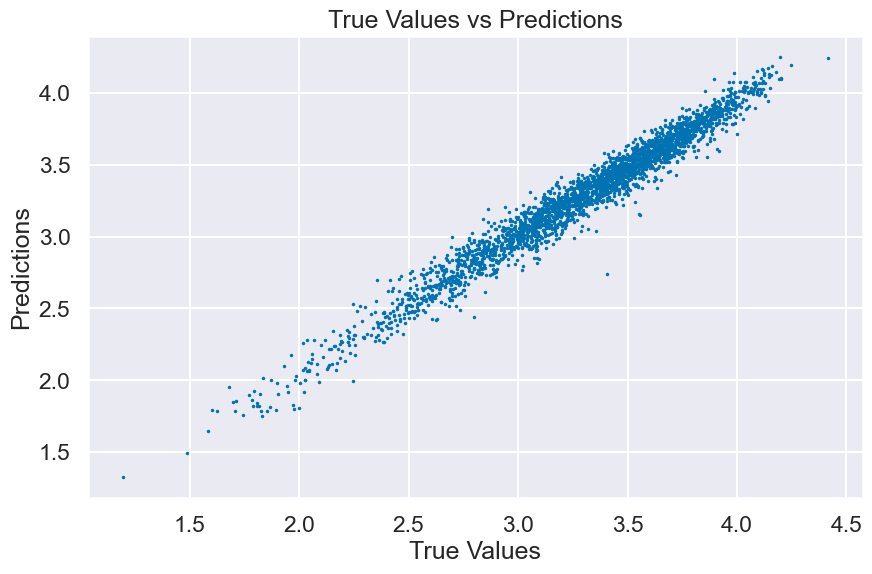

In [8]:
# Plot the results with sns
sns.set_style('darkgrid')
sns.set_context('talk')
sns.set_palette('colorblind')

plt.figure(figsize=(10, 6))
plt.scatter(Y_test, preds, s=1)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs Predictions')
plt.show()